# Part 1: Vehicle Loading/Unloading Analysis

This notebook calculates and prints loading and unloading man-hours for each vehicle type. Adjust parameters at the top as needed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# 1. Vehicle data and benchmarks
VEHICLES = [
    {"type": "50 ft ODC Trailer / Container", "L": 50, "parcels": 1500},
    {"type": "32 ft Container MXL",           "L": 32, "parcels": 1000},
    {"type": "32 ft Container SXL",           "L": 32, "parcels": 700},
    {"type": "24 ft Box/Container Truck",     "L": 24, "parcels": 600},
    {"type": "Tata 22 ft Container",          "L": 22, "parcels": 600},
    {"type": "Eicher 19 ft",                  "L": 19, "parcels": 500},
    {"type": "Eicher 17 ft",                  "L": 17, "parcels": 425},
    {"type": "Eicher 14 ft (LCV)",            "L": 14, "parcels": 300},
    {"type": "Tata 407 / Dost Bada",          "L": 10, "parcels": 215},
    {"type": "Mahindra Bolero Pickup",        "L": 9,  "parcels": 100},
    {"type": "Tata Ace / Dost",               "L": 8,  "parcels": 50},
]

opt_loading = {
    "50 ft ODC Trailer / Container": 24,
    "32 ft Container MXL": 15,
    "32 ft Container SXL": 9,
    "24 ft Box/Container Truck": 9,
    "Tata 22 ft Container": 6.125,
    "Eicher 19 ft": 4.5,
    "Eicher 17 ft": 2.8125,
    "Eicher 14 ft (LCV)": 2.1875,
    "Tata 407 / Dost Bada": 1.875,
    "Mahindra Bolero Pickup": 0.825,
    "Tata Ace / Dost": 0.525
}

opt_unloading = {
    "50 ft ODC Trailer / Container": 19.5,
    "32 ft Container MXL": 12.5,
    "32 ft Container SXL": 7,
    "24 ft Box/Container Truck": 7,
    "Tata 22 ft Container": 4.8125,
    "Eicher 19 ft": 3.75,
    "Eicher 17 ft": 2.1875,
    "Eicher 14 ft (LCV)": 1.625,
    "Tata 407 / Dost Bada": 1.375,
    "Mahindra Bolero Pickup": 0.6,
    "Tata Ace / Dost": 0.3
}

## A) Locally Optimized Parameters

▶ Optimized parameters:
  f1 (≤100 parcels):     ×1.394
  f2 (≤200 parcels):     ×1.200
  f3 (≤300 parcels):     ×1.115
  f4 (>300 parcels):     ×1.095
  Length factor α:       ×0.927
  Turning time tturn:    0.500 s/parcel
  Mean‐squared %‐error:  0.031762

=== Error Table ===


,Vehicle,Opt Load (h),Calc Load (h),Err Load (%),Opt Unld (h),Calc Unld (h),Err Unld (%)
0,50 ft ODC Trailer / Container,24.0000,23.31,2.9,19.5000,21.67,11.1
1,32 ft Container MXL,15.0000,11.51,23.3,12.5000,10.42,16.7
2,32 ft Container SXL,9.0000,8.06,10.5,7.0000,7.29,4.2
3,24 ft Box/Container Truck,9.0000,5.83,35.2,7.0000,5.18,26.0
4,Tata 22 ft Container,6.1250,5.56,9.2,4.8125,4.91,2.0
5,Eicher 19 ft,4.5000,4.30,4.4,3.7500,3.75,0.1
6,Eicher 17 ft,2.8125,3.47,23.2,2.1875,3.00,37.2
7,Eicher 14 ft (LCV),2.1875,2.28,4.4,1.6250,1.95,20.1
8,Tata 407 / Dost Bada,1.8750,1.44,23.1,1.3750,1.20,12.5
9,Mahindra Bolero Pickup,0.8250,0.81,1.8,0.6000,0.67,11.8



=== Manual vs Machine Table ===


,Vehicle,Manual Load (h),Machine Load (h),% Save Load,Manual Unld (h),Machine Unld (h),% Save Unld
0,50 ft ODC Trailer / Container,23.31,9.79,58.0,21.67,7.33,66.2
1,32 ft Container MXL,11.51,6.52,43.3,10.42,4.89,53.1
2,32 ft Container SXL,8.06,4.57,43.3,7.29,3.42,53.1
3,24 ft Box/Container Truck,5.83,3.91,32.9,5.18,2.93,43.4
4,Tata 22 ft Container,5.56,3.91,29.6,4.91,2.93,40.3
5,Eicher 19 ft,4.30,3.26,24.1,3.75,2.44,34.9
6,Eicher 17 ft,3.47,2.77,20.0,3.00,2.08,30.8
7,Eicher 14 ft (LCV),2.28,1.99,12.8,1.95,1.49,23.5
8,Tata 407 / Dost Bada,1.44,1.43,1.0,1.20,1.07,11.1
9,Mahindra Bolero Pickup,0.81,0.83,-2.5,0.67,0.62,7.3


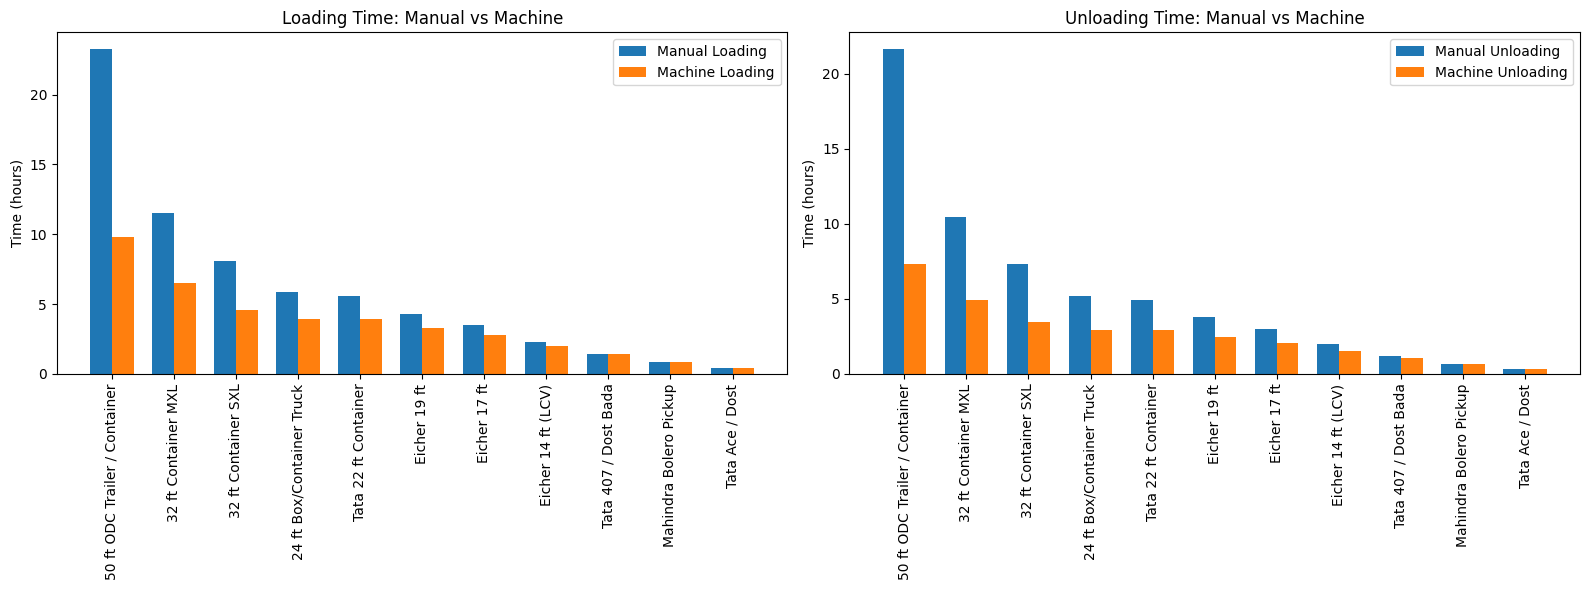

In [3]:
# 2. Constants
SPEED_WITHOUT_LOAD = 0.9   # m/s
SPEED_WITH_LOAD    = 0.67  # m/s
LOADING_DELAY      = 13.8  # s/parcel
UNLOADING_DELAY    = 10.21 # s/parcel
MACHINE_BUFFER     = 1.5  # 50% buffer factor for machine loading/unloading

# 3. Compute times given parameters [f1,f2,f3,f4, alpha, tturn]
def compute_times(params):
    f1, f2, f3, f4, alpha, tturn = params
    manual_load, manual_unld = [], []
    machine_load, machine_unld = [], []
    
    for v in VEHICLES:
        n, L_ft = v['parcels'], v['L']
        # fatigue multiplier
        if   n <= 100: fm = f1
        elif n <= 200: fm = f2
        elif n <= 300: fm = f3
        else:           fm = f4

        # walking distance (m)
        d = L_ft * 0.3048 * alpha
        # walking time (hr)
        walk_hr = ((d / SPEED_WITHOUT_LOAD) + (d / SPEED_WITH_LOAD)) * n * fm / 3600
        # handling time (hr)
        load_hr = (LOADING_DELAY + tturn)   * n * fm / 3600
        unld_hr = (UNLOADING_DELAY + tturn) * n * fm / 3600
        # machine times (hr) -- now also include fatigue multiplier and buffer
        machL = ((LOADING_DELAY + tturn)   * n * fm / 3600) * MACHINE_BUFFER
        machU = ((UNLOADING_DELAY + tturn) * n * fm / 3600) * MACHINE_BUFFER

        manual_load.append(walk_hr + load_hr)
        manual_unld.append(walk_hr + unld_hr)
        machine_load.append(machL)
        machine_unld.append(machU)
    
    return (np.array(manual_load),
            np.array(manual_unld),
            np.array(machine_load),
            np.array(machine_unld))

# 4. Loss function
def loss(params):
    mL, mU, _, _ = compute_times(params)
    errs = []
    for v, pL, pU in zip(VEHICLES, mL, mU):
        lbl = v['type']
        errs.append((pL - opt_loading[lbl])   / opt_loading[lbl])
        errs.append((pU - opt_unloading[lbl]) / opt_unloading[lbl])
    return np.mean(np.square(errs))

# 5. Optimize parameters
initial = [1.1, 1.2, 1.3, 1.4, 0.6, 2.0]  # f1,f2,f3,f4,alpha,tturn
bounds = [(1,2)]*4 + [(0.3,1.0), (0.5,5.0)]
res = minimize(loss, initial, bounds=bounds, method='L-BFGS-B')
f1, f2, f3, f4, alpha, tturn = res.x

print("▶ Optimized parameters:")
print(f"  f1 (≤100 parcels):     ×{f1:.3f}")
print(f"  f2 (≤200 parcels):     ×{f2:.3f}")
print(f"  f3 (≤300 parcels):     ×{f3:.3f}")
print(f"  f4 (>300 parcels):     ×{f4:.3f}")
print(f"  Length factor α:       ×{alpha:.3f}")
print(f"  Turning time tturn:    {tturn:.3f} s/parcel")
print(f"  Mean‐squared %‐error:  {res.fun:.6f}\n")

# 6. Recompute times
mL, mU, machL, machU = compute_times([f1, f2, f3, f4, alpha, tturn])

# 7. Build Error Table
error_rows = []
for v, pL, pU in zip(VEHICLES, mL, mU):
    lbl = v['type']
    optL, optU = opt_loading[lbl], opt_unloading[lbl]
    error_rows.append({
        "Vehicle": lbl,
        "Opt Load (h)": optL,
        "Calc Load (h)": round(pL,2),
        "Err Load (%)": round(abs(pL-optL)/optL*100,1),
        "Opt Unld (h)": optU,
        "Calc Unld (h)": round(pU,2),
        "Err Unld (%)": round(abs(pU-optU)/optU*100,1),
    })
error_df = pd.DataFrame(error_rows)

from IPython.display import display

print("=== Error Table ===")
display(error_df)

# 8. Build Manual vs Auto Table
ma_rows = []
for v, pL, pU, ML, MU in zip(VEHICLES, mL, mU, machL, machU):
    lbl = v['type']
    ma_rows.append({
        "Vehicle": lbl,
        "Manual Load (h)": round(pL,2),
        "Machine Load (h)": round(ML,2),
        "% Save Load": round(100*(1-ML/pL),1),
        "Manual Unld (h)": round(pU,2),
        "Machine Unld (h)": round(MU,2),
        "% Save Unld": round(100*(1-MU/pU),1)
    })
ma_df = pd.DataFrame(ma_rows)

print("\n=== Manual vs Machine Table ===")
display(ma_df)

# 9. Plotting
x = np.arange(len(VEHICLES))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Loading plot
ax1.bar(x - width/2, mL, width, label="Manual Loading")
ax1.bar(x + width/2, machL, width, label="Machine Loading")
ax1.set_xticks(x)
ax1.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax1.set_ylabel("Time (hours)")
ax1.set_title("Loading Time: Manual vs Machine")
ax1.legend()

# Unloading plot
ax2.bar(x - width/2, mU, width, label="Manual Unloading")
ax2.bar(x + width/2, machU, width, label="Machine Unloading")
ax2.set_xticks(x)
ax2.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax2.set_ylabel("Time (hours)")
ax2.set_title("Unloading Time: Manual vs Machine")
ax2.legend()

plt.tight_layout()
plt.show()

## B) Globally and Locally Optimized Parameters

▶ Optimized parameters:
  f1–f4: 1.296, 1.200, 1.008, 1.029
  α (length factor): 0.830
  tturn (s): 1.879
  v_walk, v_load (m/s): 0.830, 0.534
  d_load, d_unld (s): 13.96, 9.93
  Mean‐squared %‐error: 0.031819

=== Error Table ===


,Vehicle,Opt Load (h),Calc Load (h),Err Load (%),Opt Unld (h),Calc Unld (h),Err Unld (%)
0,50 ft ODC Trailer / Container,24.0000,23.47,2.2,19.5000,21.75,11.5
1,32 ft Container MXL,15.0000,11.64,22.4,12.5000,10.49,16.1
2,32 ft Container SXL,9.0000,8.15,9.4,7.0000,7.35,4.9
3,24 ft Box/Container Truck,9.0000,5.92,34.2,7.0000,5.23,25.3
4,Tata 22 ft Container,6.1250,5.65,7.7,4.8125,4.96,3.1
5,Eicher 19 ft,4.5000,4.38,2.8,3.7500,3.80,1.4
6,Eicher 17 ft,2.8125,3.53,25.5,2.1875,3.04,39.0
7,Eicher 14 ft (LCV),2.1875,2.25,2.6,1.6250,1.91,17.4
8,Tata 407 / Dost Bada,1.8750,1.42,24.2,1.3750,1.18,14.2
9,Mahindra Bolero Pickup,0.8250,0.82,0.4,0.6000,0.68,12.9



=== Manual vs Machine Table ===


,Vehicle,Manual Load (h),Machine Load (h),% Save Load,Manual Unld (h),Machine Unld (h),% Save Unld
0,50 ft ODC Trailer / Container,23.47,10.18,56.6,21.75,7.59,65.1
1,32 ft Container MXL,11.64,6.79,41.7,10.49,5.06,51.8
2,32 ft Container SXL,8.15,4.75,41.7,7.35,3.54,51.8
3,24 ft Box/Container Truck,5.92,4.07,31.2,5.23,3.04,41.9
4,Tata 22 ft Container,5.65,4.07,27.9,4.96,3.04,38.8
5,Eicher 19 ft,4.38,3.39,22.4,3.80,2.53,33.4
6,Eicher 17 ft,3.53,2.88,18.3,3.04,2.15,29.3
7,Eicher 14 ft (LCV),2.25,1.99,11.2,1.91,1.49,22.0
8,Tata 407 / Dost Bada,1.42,1.43,-0.6,1.18,1.07,9.6
9,Mahindra Bolero Pickup,0.82,0.85,-4.0,0.68,0.64,5.9


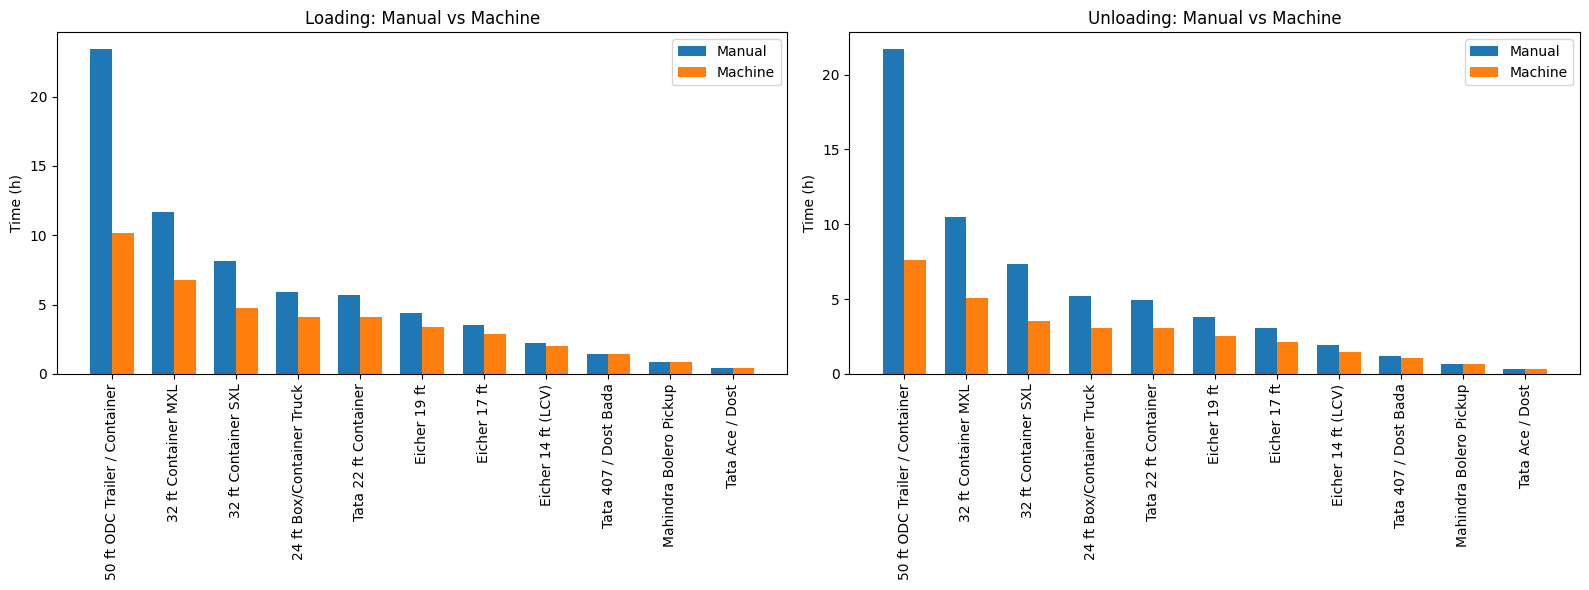

In [4]:
# 2. Compute times given all parameters as variables:
# params = [f1,f2,f3,f4, alpha, tturn, v_walk, v_load, delay_load, delay_unld]
MACHINE_BUFFER = 1.5  # 50% buffer factor for machine loading/unloading

def compute_times(params):
    f1, f2, f3, f4, alpha, tturn, v_walk, v_load, d_load, d_unld = params
    manual_load, manual_unld = [], []
    machine_load, machine_unld = [], []
    for v in VEHICLES:
        n, L_ft = v['parcels'], v['L']
        fm = f1 if n<=100 else f2 if n<=200 else f3 if n<=300 else f4
        d = L_ft * 0.3048 * alpha
        walk_hr = ((d/v_walk) + (d/v_load)) * n * fm / 3600
        load_hr = (d_load + tturn)   * n * fm / 3600
        unld_hr = (d_unld + tturn)  * n * fm / 3600
        machL = ((d_load + tturn)   * n * fm / 3600) * MACHINE_BUFFER
        machU = ((d_unld + tturn)   * n * fm / 3600) * MACHINE_BUFFER
        manual_load.append(walk_hr + load_hr)
        manual_unld.append(walk_hr + unld_hr)
        machine_load.append(machL)
        machine_unld.append(machU)
    return (np.array(manual_load),
            np.array(manual_unld),
            np.array(machine_load),
            np.array(machine_unld))

# 3. Loss = mean squared percentage error vs benchmarks
def loss(params):
    mL, mU, _, _ = compute_times(params)
    errs = []
    for v, pL, pU in zip(VEHICLES, mL, mU):
        lbl = v['type']
        errs.append((pL - opt_loading[lbl])   / opt_loading[lbl])
        errs.append((pU - opt_unloading[lbl]) / opt_unloading[lbl])
    return np.mean(np.square(errs))

# 4. Optimize all parameters
initial = [
    1.1, 1.2, 1.3, 1.4,    # f1–f4
    0.6,                   # alpha
    2.0,                   # tturn
    0.9,                   # v_walk
    0.67,                  # v_load
    13.8,                  # d_load
    10.21                  # d_unld
]
bounds = [
    (1.0, 2.0), (1.0, 2.0), (1.0, 2.0), (1.0, 2.0),  # f1–f4
    (0.3, 1.0),        # alpha
    (0.5, 5.0),        # tturn
    (0.5, 2.0),        # v_walk
    (0.3, 1.5),        # v_load
    (5.0, 20.0),       # d_load
    (5.0, 20.0)        # d_unld
]
res = minimize(loss, initial, bounds=bounds, method='L-BFGS-B')
f1,f2,f3,f4,alpha,tturn,v_walk,v_load,d_load,d_unld = res.x

print("▶ Optimized parameters:")
print(f"  f1–f4: {f1:.3f}, {f2:.3f}, {f3:.3f}, {f4:.3f}")
print(f"  α (length factor): {alpha:.3f}")
print(f"  tturn (s): {tturn:.3f}")
print(f"  v_walk, v_load (m/s): {v_walk:.3f}, {v_load:.3f}")
print(f"  d_load, d_unld (s): {d_load:.2f}, {d_unld:.2f}")
print(f"  Mean‐squared %‐error: {res.fun:.6f}\n")

# 5. Recompute with optimized params
mL, mU, machL, machU = compute_times(res.x)

# 6. Error Table
err_rows = []
for v, pL, pU in zip(VEHICLES, mL, mU):
    lbl = v['type']
    err_rows.append({
        "Vehicle": lbl,
        "Opt Load (h)": opt_loading[lbl],
        "Calc Load (h)": round(pL,2),
        "Err Load (%)": round(abs(pL-opt_loading[lbl])/opt_loading[lbl]*100,1),
        "Opt Unld (h)": opt_unloading[lbl],
        "Calc Unld (h)": round(pU,2),
        "Err Unld (%)": round(abs(pU-opt_unloading[lbl])/opt_unloading[lbl]*100,1)
    })
error_df = pd.DataFrame(err_rows)
print("=== Error Table ===")
display(error_df)

# 7. Manual vs Machine Table
ma_rows = []
for v, pL, pU, ML, MU in zip(VEHICLES, mL, mU, machL, machU):
    lbl = v['type']
    ma_rows.append({
        "Vehicle": lbl,
        "Manual Load (h)": round(pL,2),
        "Machine Load (h)": round(ML,2),
        "% Save Load": round(100*(1-ML/pL),1),
        "Manual Unld (h)": round(pU,2),
        "Machine Unld (h)": round(MU,2),
        "% Save Unld": round(100*(1-MU/pU),1)
    })
ma_df = pd.DataFrame(ma_rows)
print("\n=== Manual vs Machine Table ===")
display(ma_df)

# 8. Plotting
x = np.arange(len(VEHICLES))
w = 0.35
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# Loading
ax1.bar(x-w/2, mL, w, label="Manual")
ax1.bar(x+w/2, machL, w, label="Machine")
ax1.set_xticks(x); ax1.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax1.set_ylabel("Time (h)")
ax1.set_title("Loading: Manual vs Machine")
ax1.legend()

# Unloading
ax2.bar(x-w/2, mU, w, label="Manual")
ax2.bar(x+w/2, machU, w, label="Machine")
ax2.set_xticks(x); ax2.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax2.set_ylabel("Time (h)")
ax2.set_title("Unloading: Manual vs Machine")
ax2.legend()

plt.tight_layout()
plt.show()

# Part 2: Budget & Break-even Feasibility Analysis


=== Wage Savings Table (4 workers, per vehicle, loading & unloading, wage only) ===


,Vehicle,Manual Load Time (h/job),Machine Load Time (h/job),Load Wage Saving (₹),Manual Unld Time (h/job),Machine Unld Time (h/job),Unld Wage Saving (₹)
0,50 ft ODC Trailer / Container,5.87,2.55,1163.65,5.44,1.90,1313.12
1,32 ft Container MXL,2.91,1.70,355.32,2.62,1.27,454.97
2,32 ft Container SXL,2.04,1.19,248.73,1.84,0.89,318.48
3,24 ft Box/Container Truck,1.48,1.02,101.07,1.31,0.76,160.86
4,Tata 22 ft Container,1.41,1.02,73.04,1.24,0.76,132.83
5,Eicher 19 ft,1.09,0.85,25.83,0.95,0.63,75.66
6,Eicher 17 ft,0.88,0.72,2.10,0.76,0.54,44.45
7,Eicher 14 ft (LCV),0.56,0.50,-19.14,0.48,0.37,10.15
8,Tata 407 / Dost Bada,0.36,0.36,-33.40,0.29,0.27,-12.41
9,Mahindra Bolero Pickup,0.21,0.21,-22.91,0.17,0.16,-10.36



=== Time Saved Table (per vehicle, loading & unloading, hours saved) ===


,Vehicle,Load Time Saved (h),Unld Time Saved (h)
0,50 ft ODC Trailer / Container,3.32,3.54
1,32 ft Container MXL,1.21,1.36
2,32 ft Container SXL,0.85,0.95
3,24 ft Box/Container Truck,0.46,0.55
4,Tata 22 ft Container,0.39,0.48
5,Eicher 19 ft,0.25,0.32
6,Eicher 17 ft,0.16,0.22
7,Eicher 14 ft (LCV),0.06,0.10
8,Tata 407 / Dost Bada,-0.00,0.03
9,Mahindra Bolero Pickup,-0.01,0.01


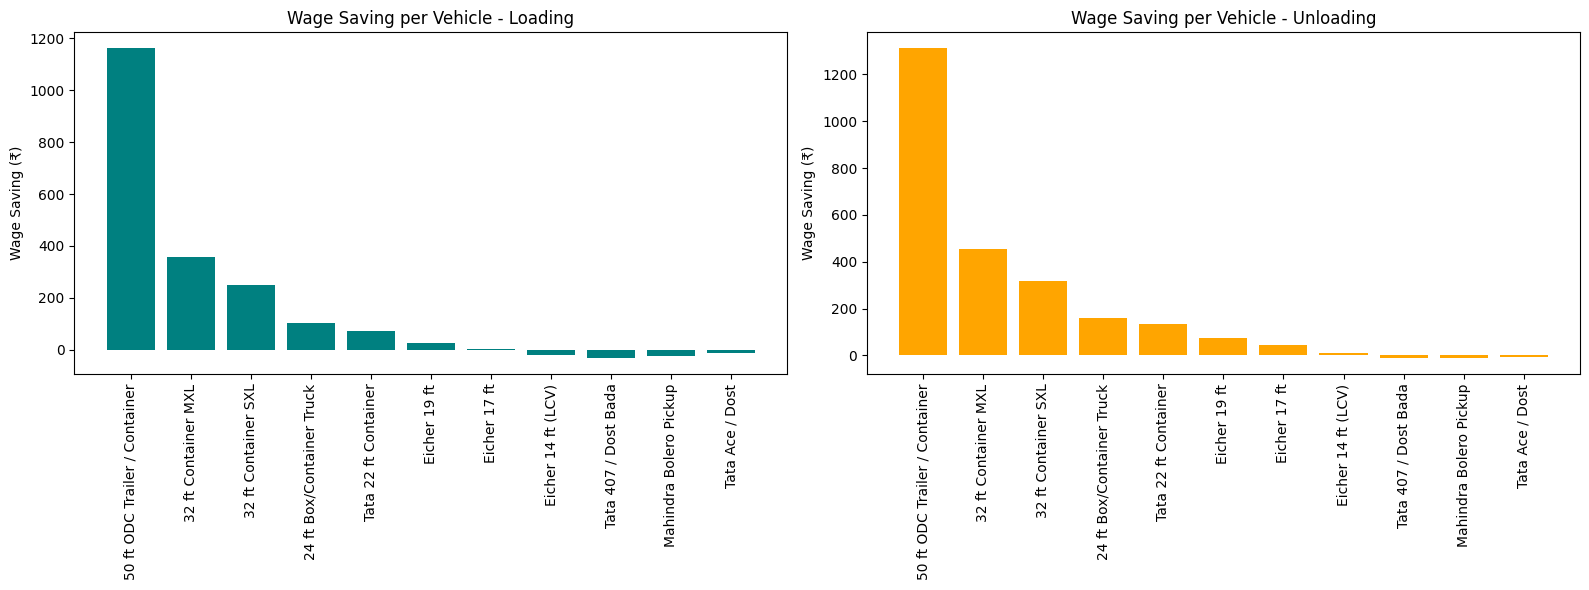

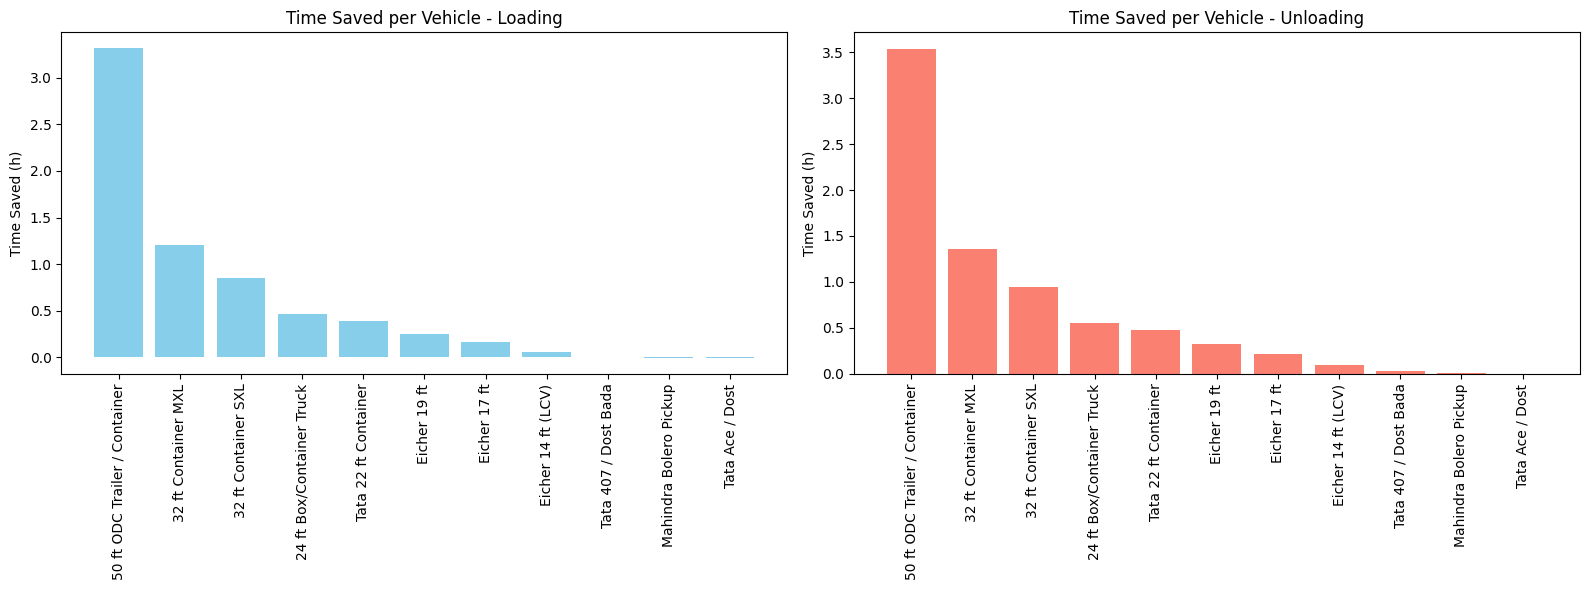

In [5]:
manual_cost_per_hour_per_worker = 105     # INR per worker per hour
num_workers = 4                          # 4 workers in both manual and machine

machine_cost = {
    "capex": 1400000,          # INR
    "opex_per_hour": 60,       # machine operation cost per hour
    "life_years": 10,
    "daily_hours": 15,         # usage per day
    "days_per_month": 25
}

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate total machine hours over its life
months = machine_cost["life_years"] * 12
total_days = months * machine_cost["days_per_month"]
total_hours = total_days * machine_cost["daily_hours"]

# Capex amortized per hour
capex_per_hour = machine_cost["capex"] / total_hours
machine_total_per_hour = capex_per_hour + machine_cost["opex_per_hour"]

# Prepare savings table for each vehicle, with only wage saving (no time saved in total)
vehicle_savings_rows = []
time_saved_rows = []

for i, v in enumerate(VEHICLES):
    name = v["type"]
    # Manual and machine times for loading and unloading (from previous calculations)
    manual_load_time_total = mL[i]    # total hours (for the job, not per worker)
    manual_unld_time_total = mU[i]
    machine_load_time_total = machL[i]
    machine_unld_time_total = machU[i]

    # Since 4 workers work together, actual time per job = total time / 4
    manual_load_time = manual_load_time_total / num_workers
    manual_unld_time = manual_unld_time_total / num_workers
    machine_load_time = machine_load_time_total / num_workers
    machine_unld_time = machine_unld_time_total / num_workers

    # Total manual and machine cost for loading
    manual_load_cost = manual_load_time * num_workers * manual_cost_per_hour_per_worker
    machine_load_cost = machine_load_time * num_workers * manual_cost_per_hour_per_worker + machine_load_time * machine_total_per_hour
    # Wage saving for loading (difference in cost per job)
    load_wage_saving = manual_load_cost - machine_load_cost
    # Time saved per job (per job, not per worker)
    load_time_saved = manual_load_time - machine_load_time

    # Total manual and machine cost for unloading
    manual_unld_cost = manual_unld_time * num_workers * manual_cost_per_hour_per_worker
    machine_unld_cost = machine_unld_time * num_workers * manual_cost_per_hour_per_worker + machine_unld_time * machine_total_per_hour
    # Wage saving for unloading (difference in cost per job)
    unld_wage_saving = manual_unld_cost - machine_unld_cost
    # Time saved per job (per job, not per worker)
    unld_time_saved = manual_unld_time - machine_unld_time

    vehicle_savings_rows.append({
        "Vehicle": name,
        "Manual Load Time (h/job)": round(manual_load_time,2),
        "Machine Load Time (h/job)": round(machine_load_time,2),
        "Load Wage Saving (₹)": round(load_wage_saving,2),
        "Manual Unld Time (h/job)": round(manual_unld_time,2),
        "Machine Unld Time (h/job)": round(machine_unld_time,2),
        "Unld Wage Saving (₹)": round(unld_wage_saving,2)
    })
    time_saved_rows.append({
        "Vehicle": name,
        "Load Time Saved (h)": round(load_time_saved,2),
        "Unld Time Saved (h)": round(unld_time_saved,2)
    })

vehicle_savings_df = pd.DataFrame(vehicle_savings_rows)
time_saved_df = pd.DataFrame(time_saved_rows)

print("\n=== Wage Savings Table (4 workers, per vehicle, loading & unloading, wage only) ===")
display(vehicle_savings_df)

print("\n=== Time Saved Table (per vehicle, loading & unloading, hours saved) ===")
display(time_saved_df)

# Plot the wage savings for loading and unloading
fig, ax = plt.subplots(1,2, figsize=(16,6))
x = np.arange(len(VEHICLES))
ax[0].bar(x, vehicle_savings_df["Load Wage Saving (₹)"], color='teal')
ax[0].set_xticks(x)
ax[0].set_xticklabels(vehicle_savings_df["Vehicle"], rotation=90)
ax[0].set_ylabel("Wage Saving (₹)")
ax[0].set_title("Wage Saving per Vehicle - Loading")

ax[1].bar(x, vehicle_savings_df["Unld Wage Saving (₹)"], color='orange')
ax[1].set_xticks(x)
ax[1].set_xticklabels(vehicle_savings_df["Vehicle"], rotation=90)
ax[1].set_ylabel("Wage Saving (₹)")
ax[1].set_title("Wage Saving per Vehicle - Unloading")

plt.tight_layout()
plt.show()

# Plot the time saved for loading and unloading separately
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].bar(x, time_saved_df["Load Time Saved (h)"], color='skyblue')
ax[0].set_xticks(x)
ax[0].set_xticklabels(time_saved_df["Vehicle"], rotation=90)
ax[0].set_ylabel("Time Saved (h)")
ax[0].set_title("Time Saved per Vehicle - Loading")

ax[1].bar(x, time_saved_df["Unld Time Saved (h)"], color='salmon')
ax[1].set_xticks(x)
ax[1].set_xticklabels(time_saved_df["Vehicle"], rotation=90)
ax[1].set_ylabel("Time Saved (h)")
ax[1].set_title("Time Saved per Vehicle - Unloading")

plt.tight_layout()
plt.show()

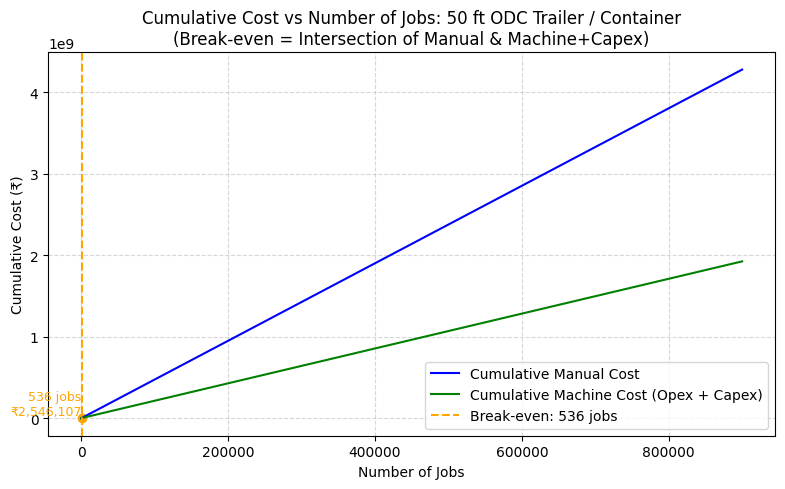

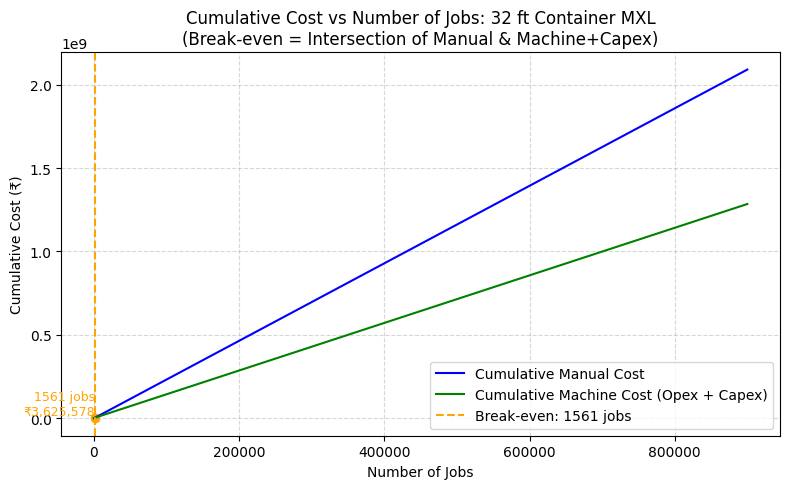

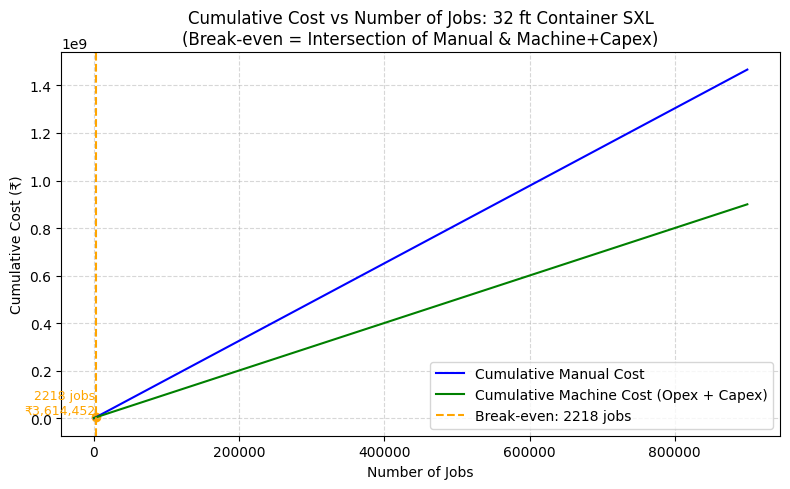

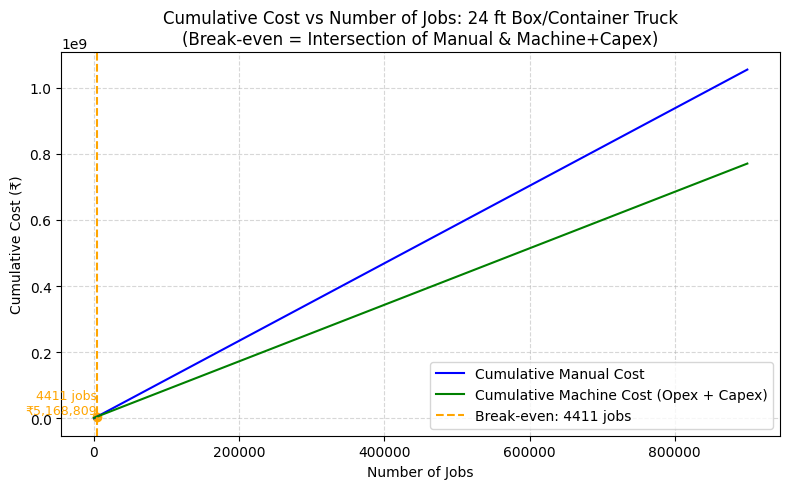

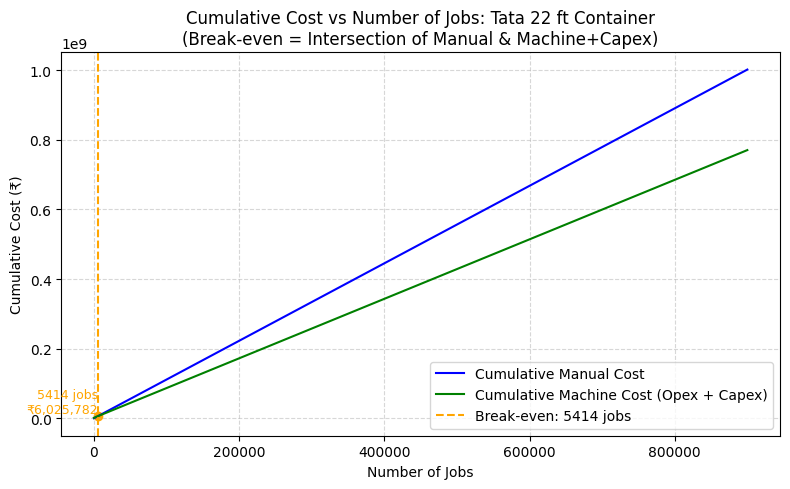

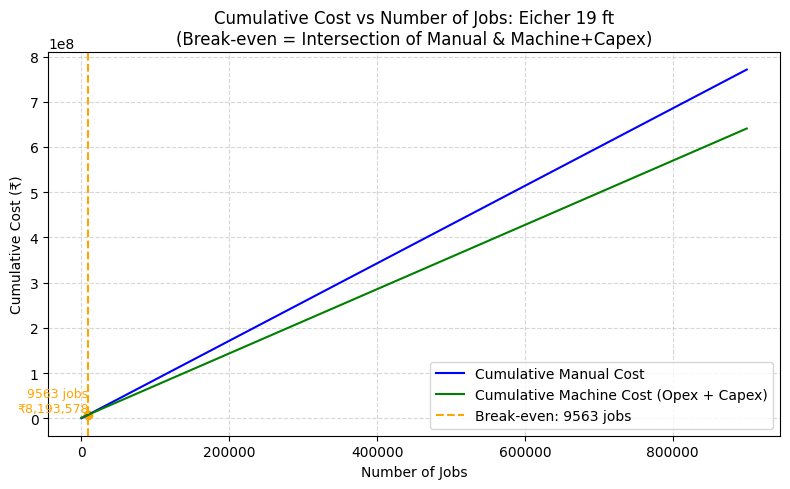

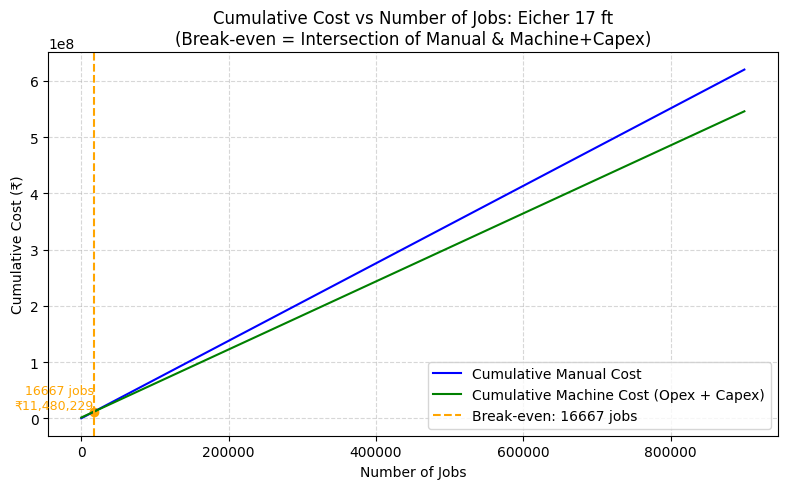

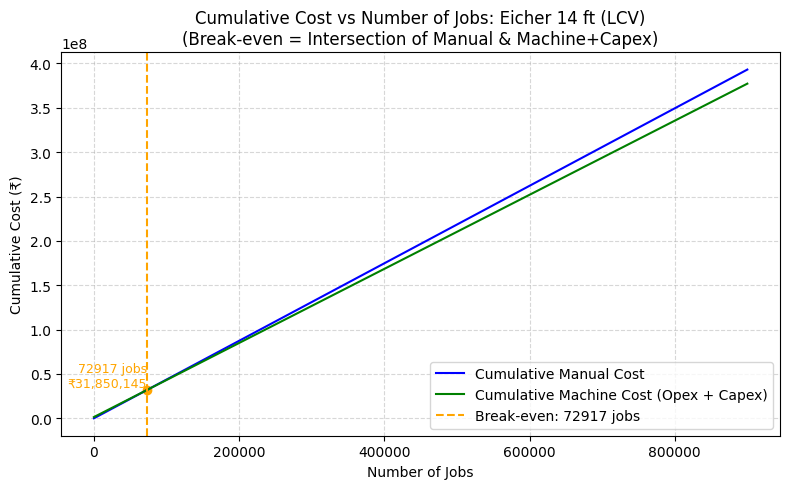

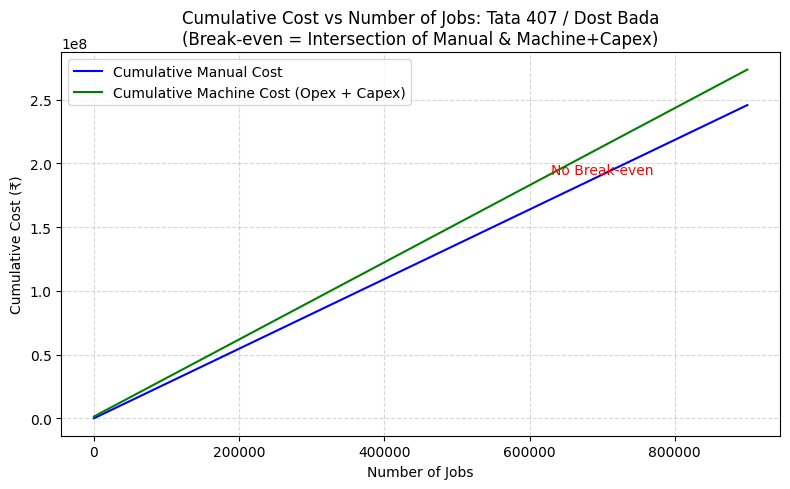

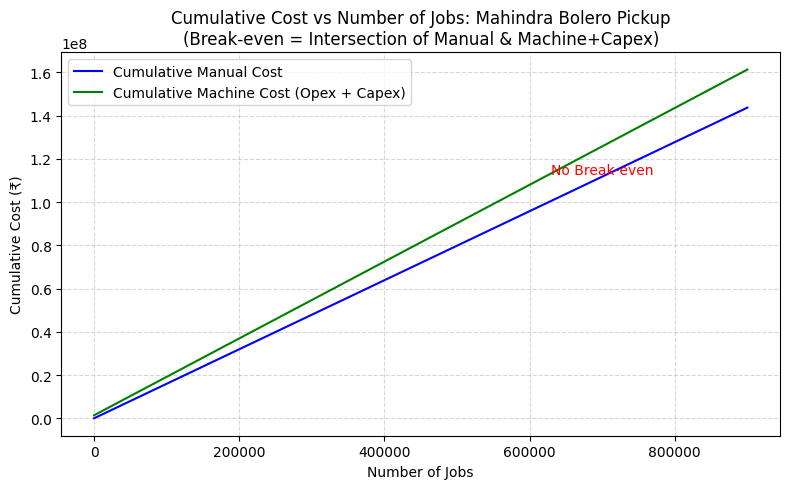

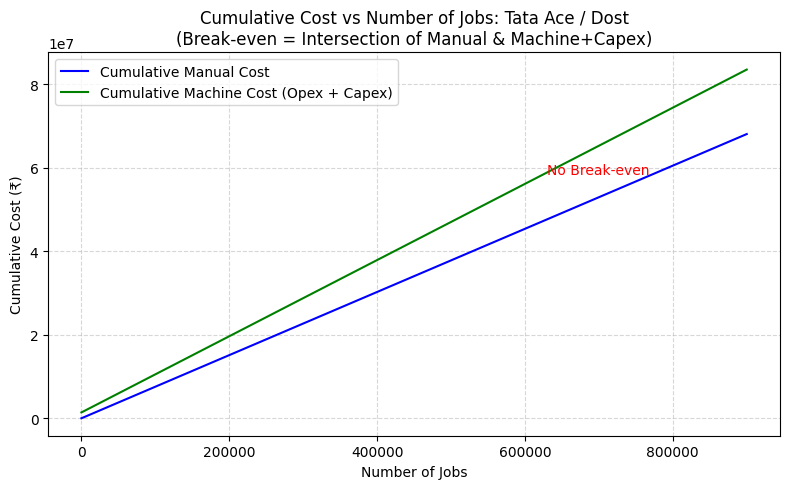

In [6]:
# For each vehicle, plot only cumulative manual cost and cumulative machine cost (with capex), and show their intersection (break-even point)
num_jobs = np.arange(0, 900001)

for i, v in enumerate(VEHICLES):
    name = v["type"]
    # Get the manual and machine times from the savings DataFrame
    row = vehicle_savings_df[vehicle_savings_df["Vehicle"] == name]
    if row.empty:
        continue

    manual_load_time = row["Manual Load Time (h/job)"].values[0]
    machine_load_time = row["Machine Load Time (h/job)"].values[0]
    manual_unld_time = row["Manual Unld Time (h/job)"].values[0]
    machine_unld_time = row["Machine Unld Time (h/job)"].values[0]

    # Manual cost per job (loading + unloading)
    manual_cost_per_job = (
        (manual_load_time + manual_unld_time) * num_workers * manual_cost_per_hour_per_worker
    )
    # Machine cost per job (loading + unloading), ONLY OPEX (NO CAPEX)
    machine_opex_per_hour = machine_cost["opex_per_hour"]  # Only opex, not capex
    machine_cost_per_job = (
        (machine_load_time + machine_unld_time) * num_workers * manual_cost_per_hour_per_worker
        + (machine_load_time + machine_unld_time) * machine_opex_per_hour
    )

    # Cumulative costs
    cumulative_manual_cost = num_jobs * manual_cost_per_job
    capex = machine_cost["capex"]
    cumulative_machine_cost = num_jobs * machine_cost_per_job + capex

    # Find intersection (break-even): where cumulative_manual_cost >= cumulative_machine_cost
    diff = cumulative_manual_cost - cumulative_machine_cost
    break_even_idx = np.argmax(diff >= 0)
    if diff[break_even_idx] < 0:
        break_even_idx = None
        break_even_jobs = None
        break_even_cost = None
    else:
        break_even_jobs = num_jobs[break_even_idx]
        break_even_cost = cumulative_manual_cost[break_even_idx]

    plt.figure(figsize=(8,5))
    plt.plot(num_jobs, cumulative_manual_cost, color='blue', label="Cumulative Manual Cost")
    plt.plot(num_jobs, cumulative_machine_cost, color='green', label="Cumulative Machine Cost (Opex + Capex)")
    if break_even_jobs is not None:
        plt.axvline(break_even_jobs, color='orange', linestyle='--', label=f'Break-even: {break_even_jobs} jobs')
        plt.scatter([break_even_jobs], [break_even_cost], color='orange')
        plt.text(
            break_even_jobs, break_even_cost,
            f"{break_even_jobs} jobs\n₹{int(break_even_cost):,}",
            va='bottom', ha='right', fontsize=9, color='orange'
        )
    else:
        plt.text(num_jobs[-1]*0.7, max(cumulative_manual_cost.max(), cumulative_machine_cost.max())*0.7, "No Break-even", color='red', fontsize=10)
    plt.title(f"Cumulative Cost vs Number of Jobs: {name}\n(Break-even = Intersection of Manual & Machine+Capex)")
    plt.xlabel("Number of Jobs")
    plt.ylabel("Cumulative Cost (₹)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()